In [1]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


*This is for simulating correlation data using Monte Carlo.*

First, we make random choice to decide which light source is used.

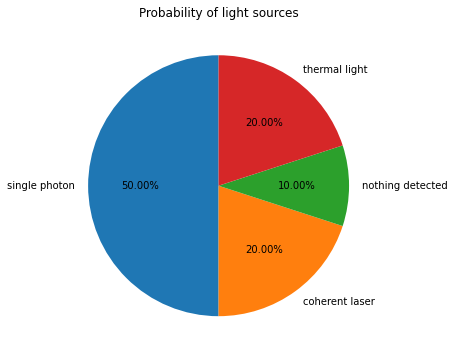

In [115]:
# define light sources

Ndetection = int(10e6)    # total detections
Nbin = 401                # total time bins
N = Ndetection / Nbin     # average co-detections per bin

bin_array = tf.range(total_bin//2 * (-1) ,total_bin//2+1,delta=1,dtype=float32)
bin_n = tf.constant(np.linspace(min(bin_array),-1,total_bin//2),dtype=float32)
bin_p = tf.constant(np.linspace(1,max(bin_array),total_bin//2),dtype=float32)
exp_rate = 1.       # exponential rate
n = 1              # identical single photon emitters
zeroth = 1 - (1/n)  # correlation at zero delay


p_sps = 0.5         #  probability of a single photon source
p_laser = 0.2      # probability of a coherent laser source
p_non = 0.1         # probability of getting nothing / 2nd photon is not in the range of abs time range
p_ther = 0.2       # probability of a thermal light source

lightsource = {
    'single photon': p_sps,
    'coherent laser': p_laser,
    'nothing detected': p_non,
    'thermal light': p_ther,
    }

#source_dist = tf.random.categorical(tf.math.log([[i for i in lightsource.values()]]), Ndetection)
#[len(np.where(source_dist[0].numpy()==i)[0])for i in range(len(lightsource))]


fig,ax = plt.subplots(1,1)
ax.pie([i for i in lightsource.values()],
       labels=[i for i in lightsource.keys()],autopct='%1.2f%%',startangle=90)
ax.set_title('Probability of light sources')
fig.show()

#plt.polar(source[0].numpy(),label='event')
#plt.ylabel('event type',fontsize=15)
#plt.xticks([0,1,2],['single photon','laser','nothing'])
#plt.legend(loc=(0,1.02))


---
# single photon source
We first simulate the single photon source case. For an ideal single photon emitter, it's not possible for two detectors to detect photons at the same time, resulting a dip (zero probability) at zero time delay while equal probability for all other time bins. 

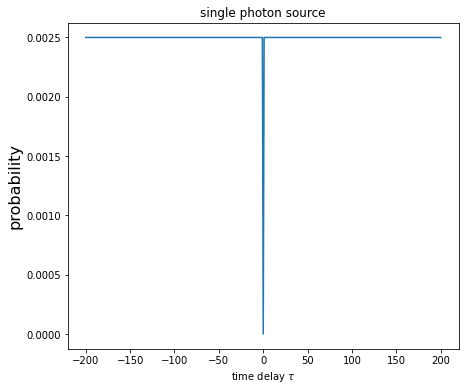

In [146]:
# single photon distribution

sps_dist = tfd.MixtureSameFamily(
    mixture_distribution = 
    tfd.Categorical(probs=[bin_n.shape[0]/(Nbin+0),0/Nbin, bin_p.shape[0]/(Nbin+0)]),
    # probability to get the second photon at a time slot
    
    components_distribution = 
    #tfd.Exponential(rate=exp_rate),
    tfd.Uniform(low=[min(bin_array),0.,1],high=[0,0.,max(bin_array)+1])
                       )

sps_prob = sps_dist.prob(bin_array+0.2)
#sps_prob = tf.concat([sps_prob[0],[0],sps_prob[1]],0)
fig, ax = plt.subplots()
ax.plot(bin_array,sps_prob)
ax.set_title('single photon source')
ax.set_xlabel(r'time delay $\tau$')
ax.set_ylabel('probability',size=16)
fig.show()


### test the single photon case

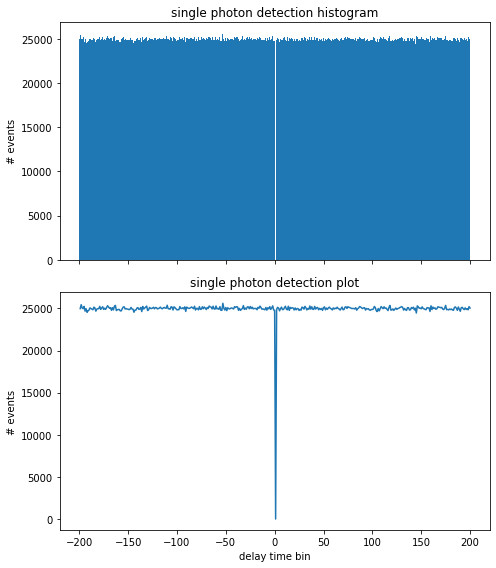

In [163]:
# sampling from the distribution
counts = Ndetection
samples = sps_dist.sample(counts)
#samples = tf.cast(sps_dist.sample(counts),dtype=int32)

fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
#f1 = plt.figure(1)
histoinfo=axs[0].hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )  
axs[0].set_title('single photon detection histogram')
axs[0].set_ylabel('# events')

#f2 = plt.figure(2)
axs[1].plot(histoinfo[1][1:],histoinfo[0][0:])
axs[1].set_title('single photon detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
fig.show()

fig.tight_layout()

---
### nothing detected
The case no photon is detected, which is trivial since probabilities for all time bins are zero.

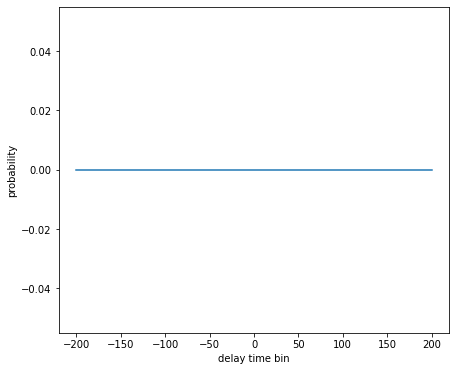

In [179]:
# no photons detected

non_dist = tfd.Uniform(low=10000.,high=10000.)
non_prob = non_dist.prob(bin_array)
fig, ax = plt.subplots(1,1)
ax.plot(bin_array,non_prob)
ax.set_xlabel('delay time bin')
ax.set_ylabel('probability')
fig.show()


---
### coherent laser
Here we simulate a perfectly coherent light source and the temporal distrubition of detecting the second photon is uniform.

In [ ]:
# coherent laser
laser_dist = tfd.Uniform(low=min(bin_array),high=max(bin_array)+1)
laser_prob = laser_dist.prob(bin_array)

# sampling from the distribution
samples = laser_dist.sample(counts)

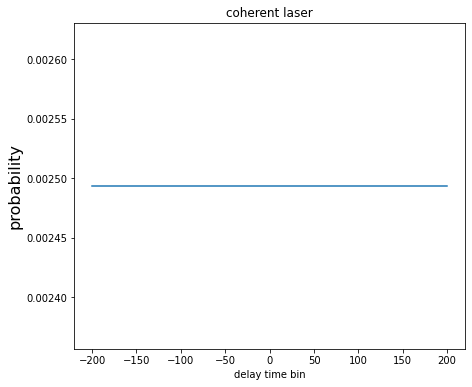

<Figure size 504x432 with 0 Axes>

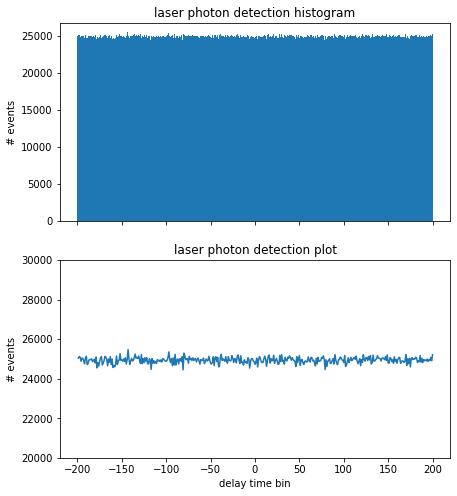

In [181]:
# plot the result
plt.figure(1)
plt.plot(bin_array,laser_prob)
plt.title('coherent laser')
plt.xlabel('delay time bin')
plt.ylabel('probability',size=16)
plt.show()

plt.figure(2)
fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
histoinfo=axs[0].hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )  
axs[0].set_title('laser photon detection histogram')
axs[0].set_ylabel('# events')
fig.show()

axs[1].plot(histoinfo[1][1:],histoinfo[0][0:])
axs[1].set_title('laser photon detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
axs[1].set_ylim(20000,30000)
plt.show()

fig.tight_layout()



---
### thermal light source
    

---
## Combine above situations

In [18]:
total_dist = tfd.Mixture(
    cat = tfd.Categorical(probs=[p_sps,p_non,p_laser]),
    components = [sps_dist,sps_dist,ther_dist] )

simu_samples = total_dist.sample(counts)

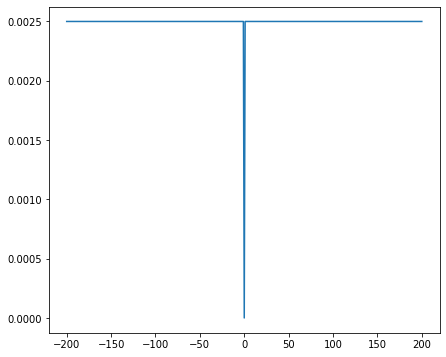

In [19]:
plt.plot(bin_array,total_dist.prob(bin_array+0.1))

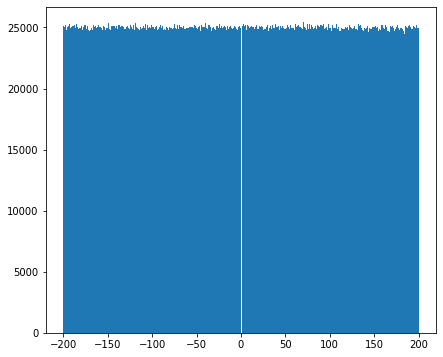

In [20]:
histoinfo_total=plt.hist(simu_samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )
#plt.savefig('sps')
#plt.xlim(-10,20)

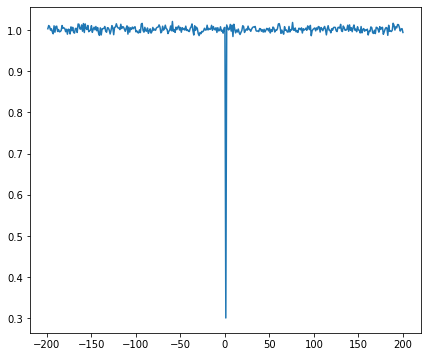

In [15]:
# normalize it
plt.plot(histoinfo_total[1][1:],histoinfo_total[0][0:]/np.average(histoinfo_total[0][:Ndetection//2-1]))
#plt.savefig('sps_')

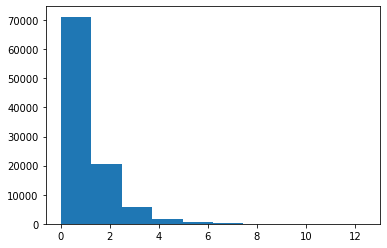

In [3]:
# sample the exponential
sam = tfd.Exponential(rate=1.0).sample(100000)
#plt.plot(np.trapz(sam))
hist = plt.hist(sam.numpy())
plt.show()

### check plt.hist

In [16]:
min(bin_info[1],bin_info[0])

NameError: name 'bin_info' is not defined

In [ ]:
a=bin_info[0][0:]
b=bin_info[1][1:]
b[a==0]

In [ ]:
x=np.random.uniform(low=-10,high=10,size=10000)
k=plt.hist(x,bins=np.ndarray.tolist(np.arange(-10,11) ))

In [ ]:
k

In [ ]:
plt.scatter(np.arange(10000),x)

In [ ]:
x1=np.random.random_integers(low=2,high=10,size=100)
plt.hist(x1,bins=8)

In [ ]:
int(-200.3)

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# Define a single scalar Normal distribution.
dist = tfd.Normal(loc=0., scale=3.)

# Evaluate the cdf at 1, returning a scalar.
dist.cdf(1.)

# Define a batch of two scalar valued Normals.
# The first has mean 1 and standard deviation 11, the second 2 and 22.
dist = tfd.Normal(loc=[-2, 2.], scale=[1.,1])

# Evaluate the pdf of the first distribution on 0, and the second on 1.5,
# returning a length two tensor.
dist.prob([-2.,2])

# Get 3 samples, returning a 3 x 2 tensor.
#dist.sample([5])


In [ ]:
# samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
samples = tf.random.categorical([[pthermal,psps,pnon]], 50)
plt.scatter(np.arange(50),samples[0])

In [ ]:
samples.numpy()

In [ ]:
six_way_multinomial = tfd.Multinomial(total_count=1000., probs=[.3, .25, .2, .15, .08, .02])
six_way_multinomial.log_prob([500., 100., 100., 150., 100., 50.])


In [ ]:
#six_way_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])
tfb = tfp.bijectors
transformed_multinomial = tfd.TransformedDistribution(
    distribution=six_way_multinomial,
    bijector=tfb.Reshape(event_shape_out=[2, 3]))
transformed_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])